In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hclust
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree

In [2]:
df_log = pd.read_csv("CGS_data/data/SRP073813/SRP073813_log.csv")
df_meta = pd.read_csv("CGS_data/data/SRP073813/SRP073813_meta.csv")

In [3]:
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True) #Setting the index for data makes the enrichment analysis easier
df_meta = df_meta['refinebio_subject'] #removes unnecessary data 

In [4]:
df_meta = df_meta.to_frame()

In [5]:
df_log =round(df_log) 
df_log = df_log.T #swaps columns and indexes which allows the deseq to run 
df_log = df_log.join(df_meta)

In [6]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()] #removes duplicate columns prevent deseq

In [7]:
#Transfomring the data to contain only data collected from a certain part of the brain in our patients 
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')] 

In [8]:
df_log.set_index("refinebio_subject", inplace = True)

In [9]:
df_log = df_log.T

In [46]:
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)
dfTen = df.head(10)
dfHun = df.head(100)
dfThous = df.head(1000)
dfTenThous = df.head(10000)
dfFiveThous = df.head(5000)
df.drop("variance", axis =1, inplace = True)

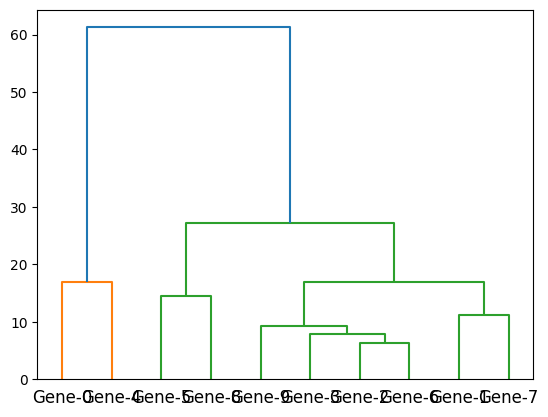

In [11]:
linkage_matrix = hclust.linkage(dfTen, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTen.shape[0])])
plt.show()

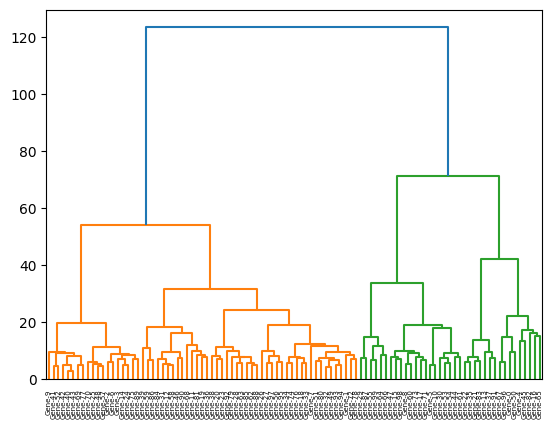

In [12]:
linkage_matrix = hclust.linkage(dfHun, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfHun.shape[0])])
plt.show()

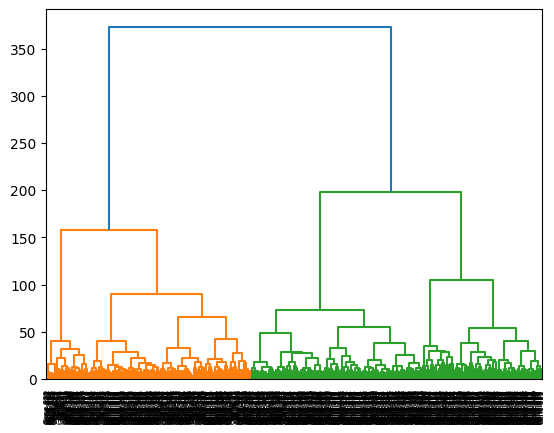

In [13]:
linkage_matrix = hclust.linkage(dfThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfThous.shape[0])])
plt.show()

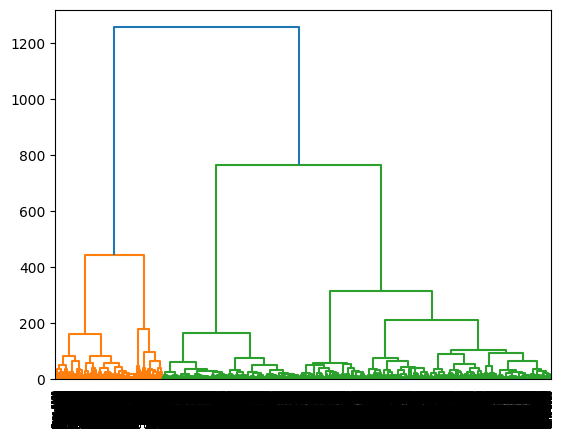

In [14]:
linkage_matrix = hclust.linkage(dfTenThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTenThous.shape[0])])
plt.show()

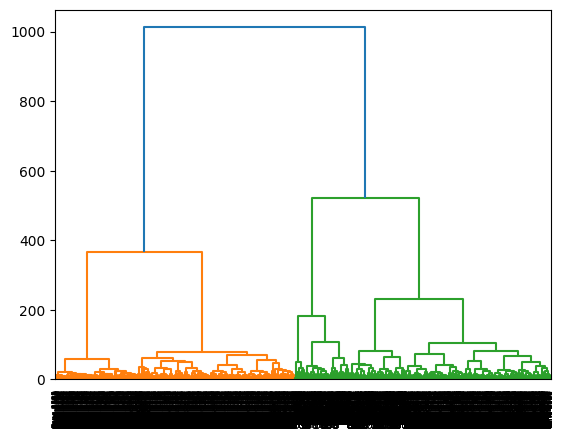

In [15]:
linkage_matrix = hclust.linkage(dfFiveThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])
plt.show()

In [16]:
dfFiveThous

refinebio_subject,nacc_schizophrenia,nacc_control,nacc_control,nacc_schizophrenia,nacc_control,nacc_control,nacc_control,nacc_control,nacc_control,nacc_control,...,nacc_major depression,nacc_bipolar disorder,nacc_schizophrenia,nacc_control,nacc_major depression,nacc_schizophrenia,nacc_schizophrenia,nacc_schizophrenia,nacc_schizophrenia,variance
CHI3L1,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,...,4.0,7.0,2.0,3.0,2.0,3.0,3.0,5.0,6.0,1.774469
PENK,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,5.0,6.0,3.0,6.0,5.0,2.0,3.0,3.0,5.0,1.299861
PTPN5,6.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,...,6.0,6.0,3.0,7.0,6.0,3.0,5.0,5.0,6.0,1.139812
SYNDIG1L,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,6.0,6.0,5.0,6.0,7.0,3.0,6.0,4.0,6.0,1.134503
XIST,4.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.126885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENAM,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.230302
LINC01980,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.230302
ICE2,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0.230302
ZXDC,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,0.230302


C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


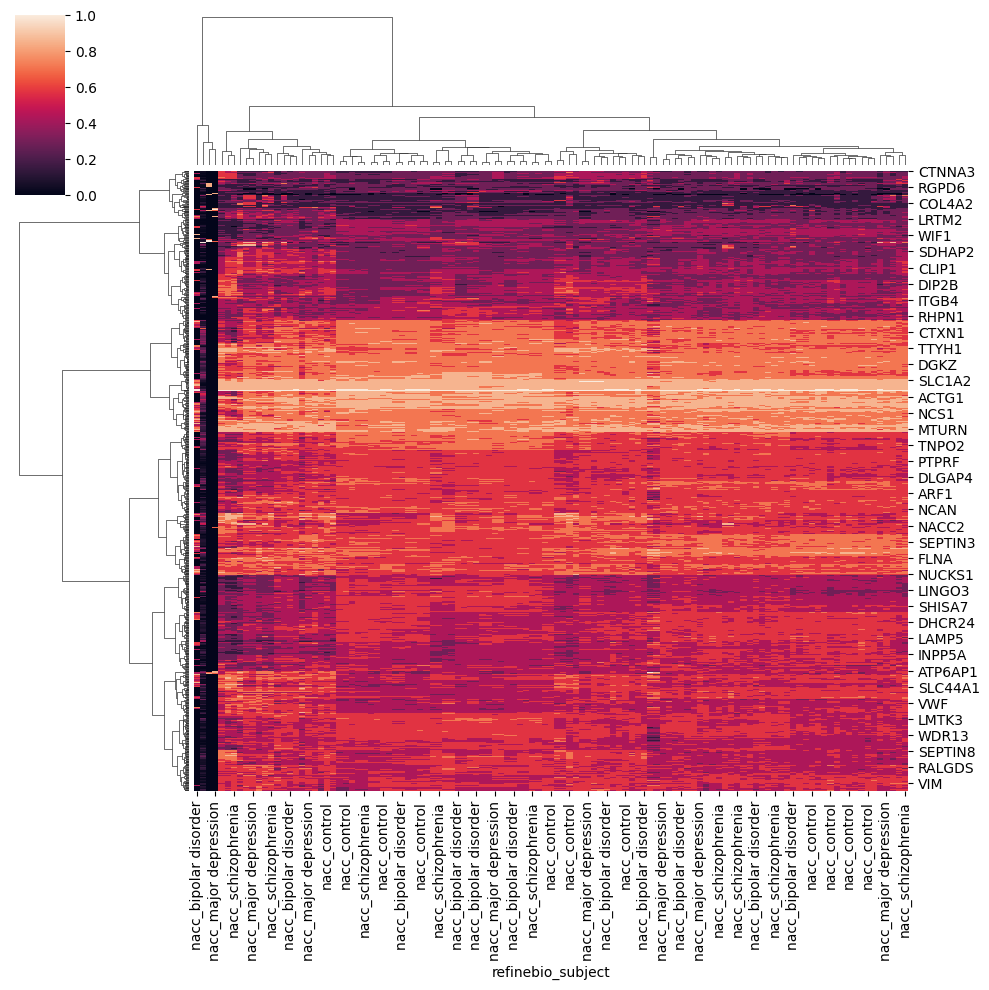

In [38]:
sns.clustermap(dfThous, metric="euclidean", standard_scale=1, method="ward")
plt.show()

In [27]:
df.to_csv("nacc_Var.csv")

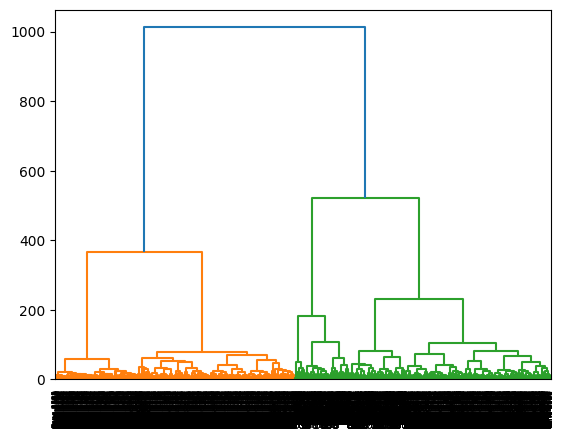

In [22]:
dend = hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])

In [47]:

# Load the data
data = df

# Define the number of clusters
num_clusters = 3

# Define a function to perform hierarchical clustering and return cluster memberships
def hierarchical_clustering(data, num_clusters, method='ward'):
    # Calculate the distance matrix
    distance_matrix = pdist(data.transpose(), 'euclidean')
    distance_matrix = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method=method)
    
    # Cut the dendrogram to get cluster labels
    cluster_labels = cut_tree(linkage_matrix, n_clusters=num_clusters).flatten()
    
    return cluster_labels

# Define subsets for clustering
gene_subsets = [10, 100, 1000, 10000]

# Store results
results = {}

for subset in gene_subsets:
    top_genes = data.var(axis=1).nlargest(subset)
    data_subset = data.loc[top_genes.index]
    
    # Get cluster memberships for the subset
    cluster_labels = hierarchical_clustering(data_subset, num_clusters)
    
    results[f"X{subset}"] = cluster_labels

# Convert results to DataFrame and save to CSV
df = pd.DataFrame(results)
df['Sample'] = data.columns
df.to_csv("CGS_Data/data/SRP073813/Sankey_plot.csv", index=False)


C:\Users\Shlok\AppData\Local\Temp\ipykernel_3224\264894347.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=method)
C:\Users\Shlok\AppData\Local\Temp\ipykernel_3224\264894347.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=method)
C:\Users\Shlok\AppData\Local\Temp\ipykernel_3224\264894347.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=method)
C:\Users\Shlok\AppData\Local\Temp\ipykernel_3224\264894347.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  l

In [48]:
df

,X10,X100,X1000,X10000,Sample
0,0,0,0,0,nacc_schizophrenia
1,0,0,0,0,nacc_control
2,0,0,0,0,nacc_control
3,0,0,0,0,nacc_schizophrenia
4,0,0,0,0,nacc_control
...,...,...,...,...,...
109,0,0,0,0,nacc_major depression
110,1,1,1,1,nacc_schizophrenia
111,1,1,1,1,nacc_schizophrenia
112,1,1,1,1,nacc_schizophrenia
